# Packages

Import required packages

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plot
import filter
import normalize

# Load Data

Here we load and preprocess data from CSV file

In [2]:
df_file_loc = "../data/2015/SWaT_Dataset_Attack_v0.csv"

df = pd.read_csv(df_file_loc)
print(df.shape)
df_total_rows = int(df.shape[0])

# Dataset Start Time and End Time
df_time_start = 0
df_time_end = 0

for index, row in df.iterrows():
    if index == 1:
        timestamp, _ = normalize.date_time(row["Timestamp"])
        print("timestamp_start=%s" %(timestamp))
        df_time_start = np.array(timestamp, dtype=np.datetime64)
    
    if index == df_total_rows-2:
        timestamp, _ = normalize.date_time(row["Timestamp"])
        print("timestamp_end=%s" %(timestamp))
        df_time_end = np.array(timestamp, dtype=np.datetime64)

df.reset_index()
df.head()

(449919, 53)
timestamp_start=2015-12-28T10:00:01
timestamp_end=2016-01-02T02:59:58


,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,28/12/2015 10:00:00 AM,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal
1,28/12/2015 10:00:01 AM,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,Normal
2,28/12/2015 10:00:02 AM,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,Normal
3,28/12/2015 10:00:03 AM,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,Normal
4,28/12/2015 10:00:04 AM,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,...,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,Normal


## Detect anomalies from input data

We can get the information about attacks from SWaT dataset `data/2015/List_of_attacks_Final.xlsx. They represent are divided into groups:

- Single stage single point (SSSP)
- Single stage multi point (SSMP)
- Multi stage single point (MSSP)
- Multi stage multi point attacks (MSMP)
 

In [3]:
attacks_file_loc = "../data/2015/List_of_attacks_Final.xlsx"
xlsx = pd.read_excel(attacks_file_loc, sheet_name="Sheet1")

anomalies = []
stages = {}

for index, row in xlsx.iterrows():
    try:
        # skip if there is no attack
        try:
            tmp = int(row["Attack #"])
        except:
            continue

        # skip if there is no attack
        attack_point = str(row["Attack Point"])
        attack_point = attack_point.replace(";", ",")
        tmp = attack_point.split(",")
        if row["Attack Point"] == "No Physical Impact Attack":
            continue

        # extract attack start time
        time_start, time_start_date = normalize.date_time(row["Start Time"])

        # extract attack end time
        time_end = str(row["End Time"])
        time_end = "%sT%s" %(time_start_date, time_end)

        # extract attack points
        attack_points = {}
        attack_stages = {}
        for i in tmp:
            i = i.strip(" ")
            i = i.upper()
            i = i.replace("-", "")
            attack_points[i] = ""
            stage = filter.get_stage(i)
            attack_stages[stage] = ""

            if stage not in stages.keys():
                stages[stage] = {}
            stages[stage][i] = ""


        attack_points = list(attack_points.keys())
        attack_stages = list(attack_stages.keys())

        # define anomaly
        anomaly = {
            "time_start": np.array(time_start, dtype=np.datetime64),
            "time_end": np.array(time_end, dtype=np.datetime64),
            "attack_points": attack_points,
            "attack_stages": attack_stages,
        }

        anomalies.append(anomaly)
    except:
        print("Error: %s" %(str(sys.exc_info())))
        print("Row value: %s" %(row))
        print("Index: %d" %(index))

# sort fields
for key in stages.keys():
    stages[key] = list(stages[key].keys())
    print(key, stages[key])

print("Loaded %d anomalies\n" %(len(anomalies)))



P1 ['MV101', 'P102', 'LIT101', 'P101']
P5 ['MV504', 'AIT504', 'AIT502', 'P501', 'FIT502']
P2 ['AIT202', 'P203', 'P205', 'P201', 'MV201']
P3 ['LIT301', 'DPIT301', 'MV304', 'MV303', 'DIT301', 'MV302', 'P302']
P4 ['FIT401', 'UV401', 'LIT401', 'P401', 'AIT402']
P6 ['P602']
Loaded 36 anomalies



## Plot all

AttributeError: 'int' object has no attribute 'iloc'

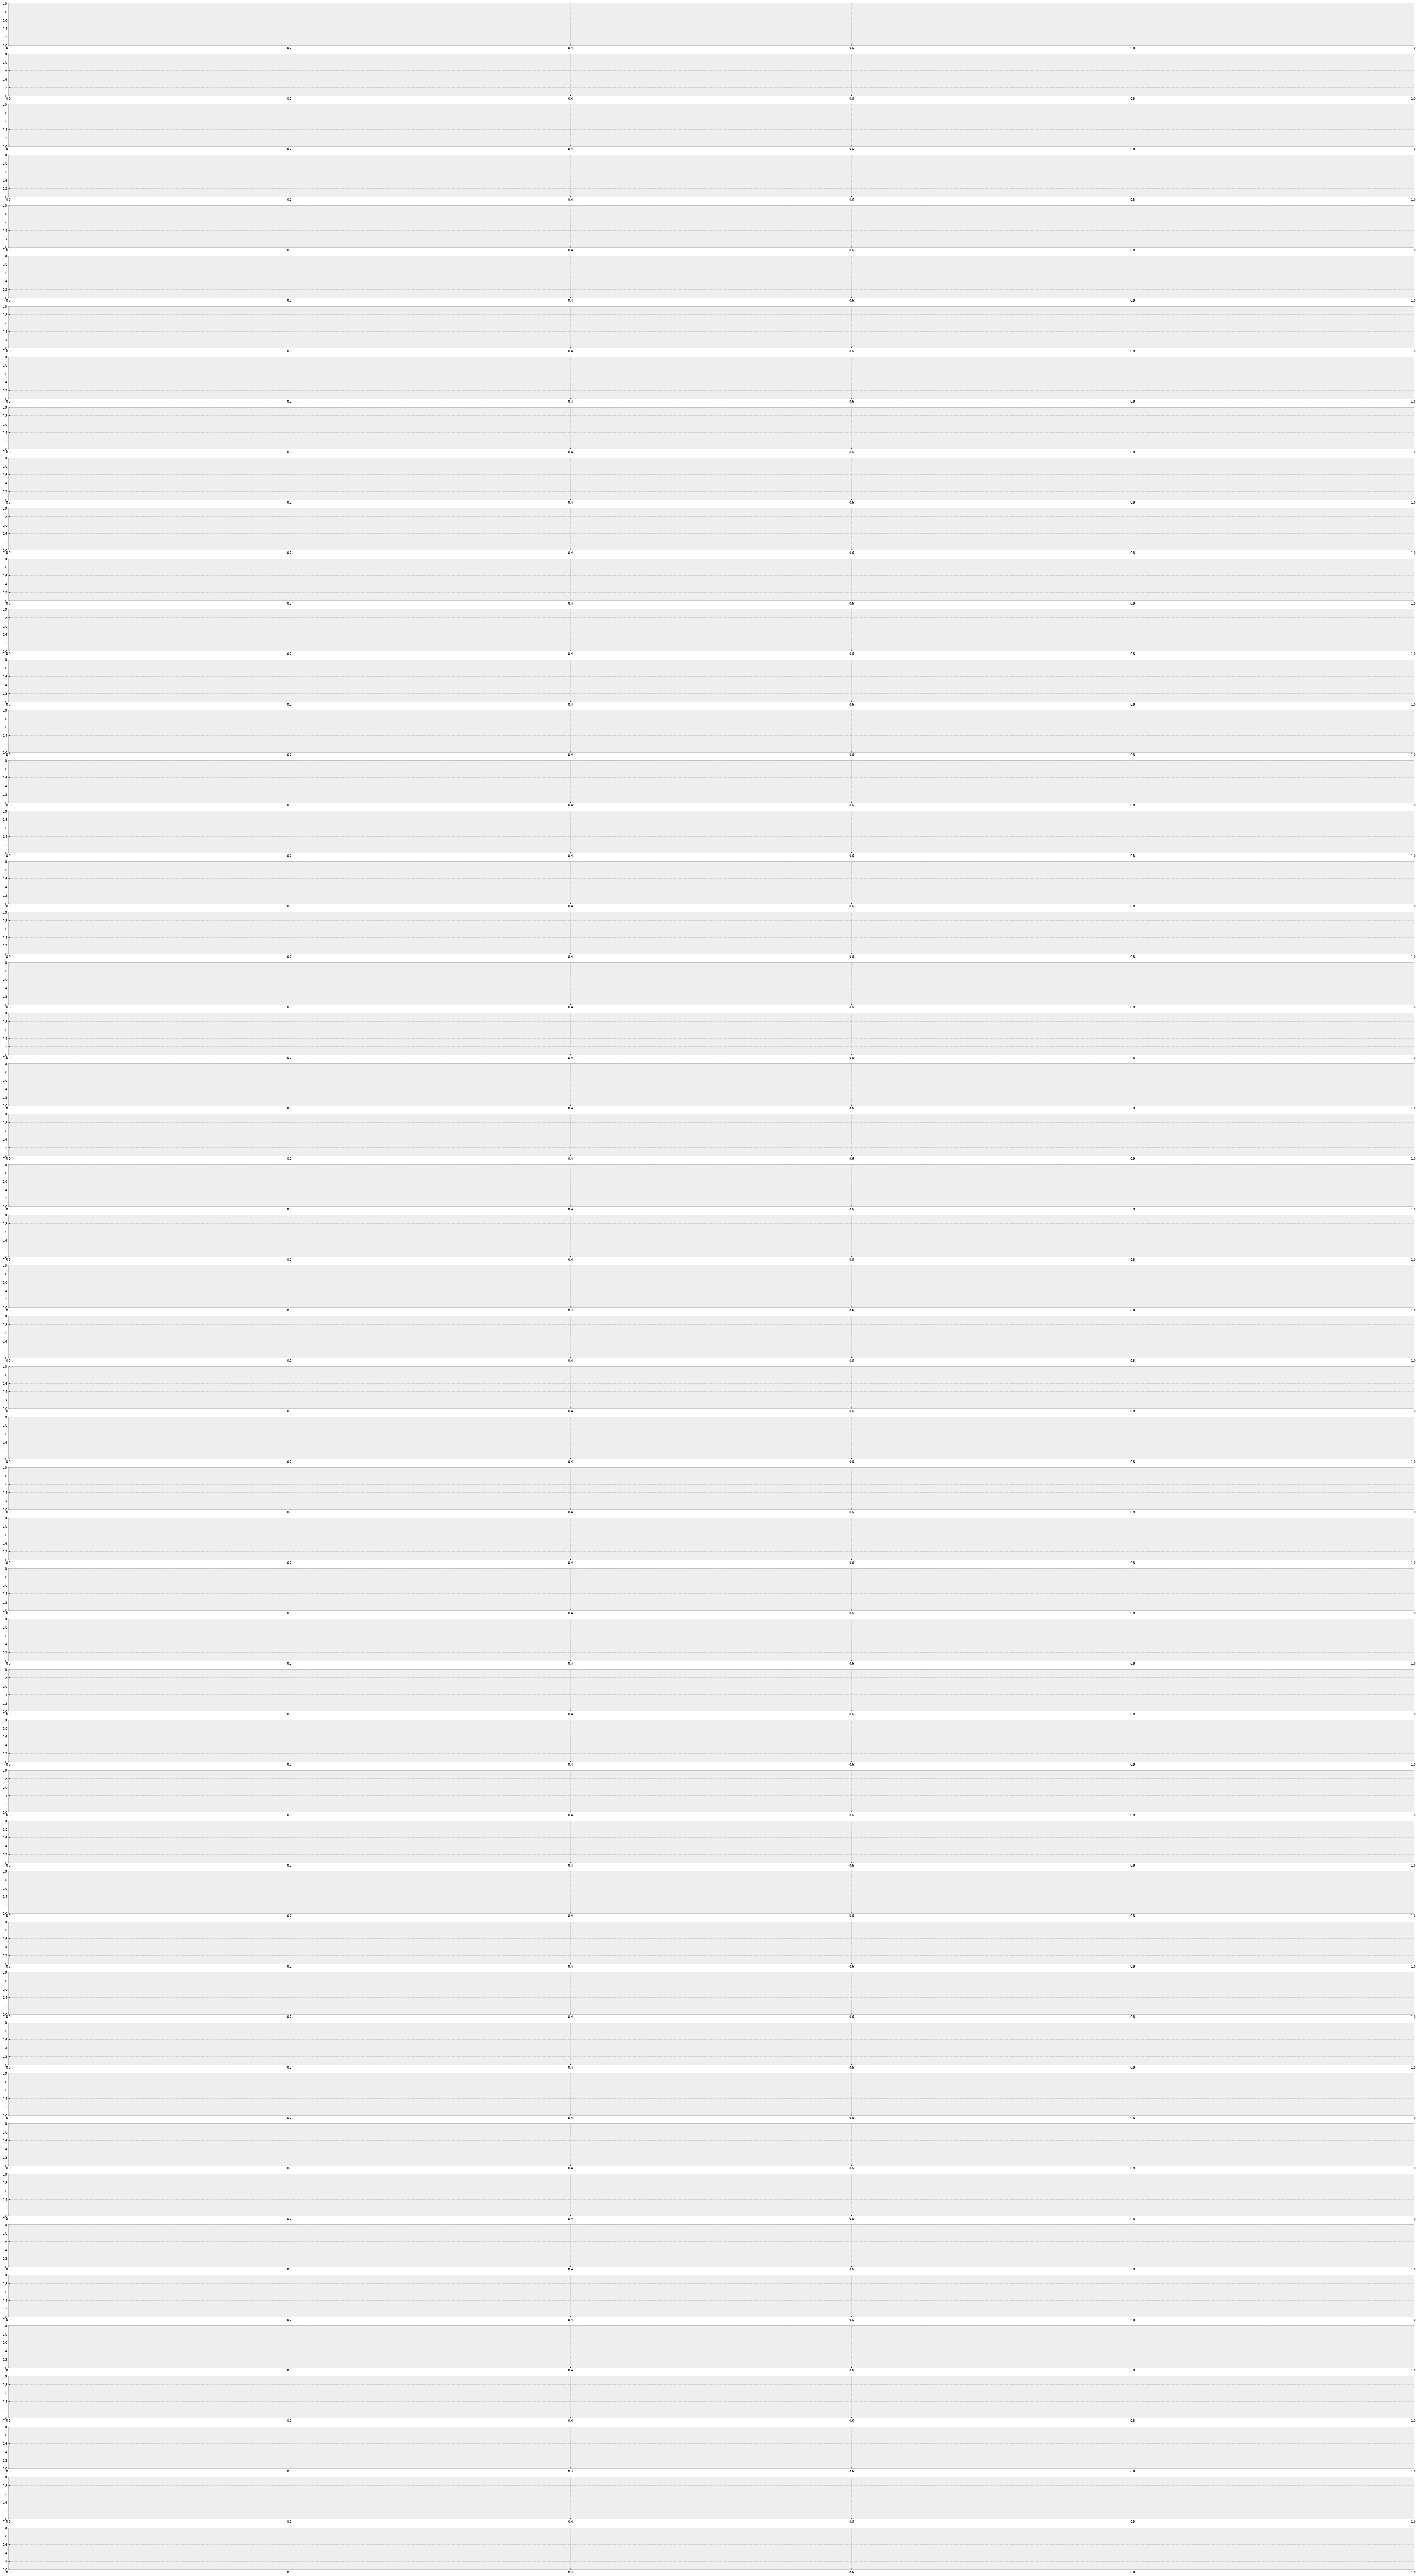

In [7]:
# Visualize all
time_delta = np.timedelta64(1, "s")
time_start, time_end = filter.get_times(anomalies, None)
time_len = int((time_end - time_start) / time_delta)

x = time_start + np.arange(0, time_len, 1)
idx_start = int((time_start - df_time_start) / time_delta)
idx_end = int((time_end - df_time_start) / time_delta)

total_columns = int(df.shape[1])-2

obj = {
    "file_loc": "../output/all.png", 
    "df": df, 
    "total_columns": total_columns, 
    "time_start": time_start, 
    "time_delta": time_delta, 
    "idx_start": idx_start, 
    "idx_end": idx_end,
    "anomalies": anomalies,
    "x": x
}
plot.process(obj)



## Plot per stage (P1, P2, P3, P4, P5, P6)

Here we plot per stage what is and where happening

(449919, 4)
     LIT101  MV101  P101  P102
0  522.8467      2     2     1
1  522.8860      2     2     1
2  522.8467      2     2     1
3  522.9645      2     2     1
4  523.4748      2     2     1
4


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


IndexError: single positional indexer is out-of-bounds

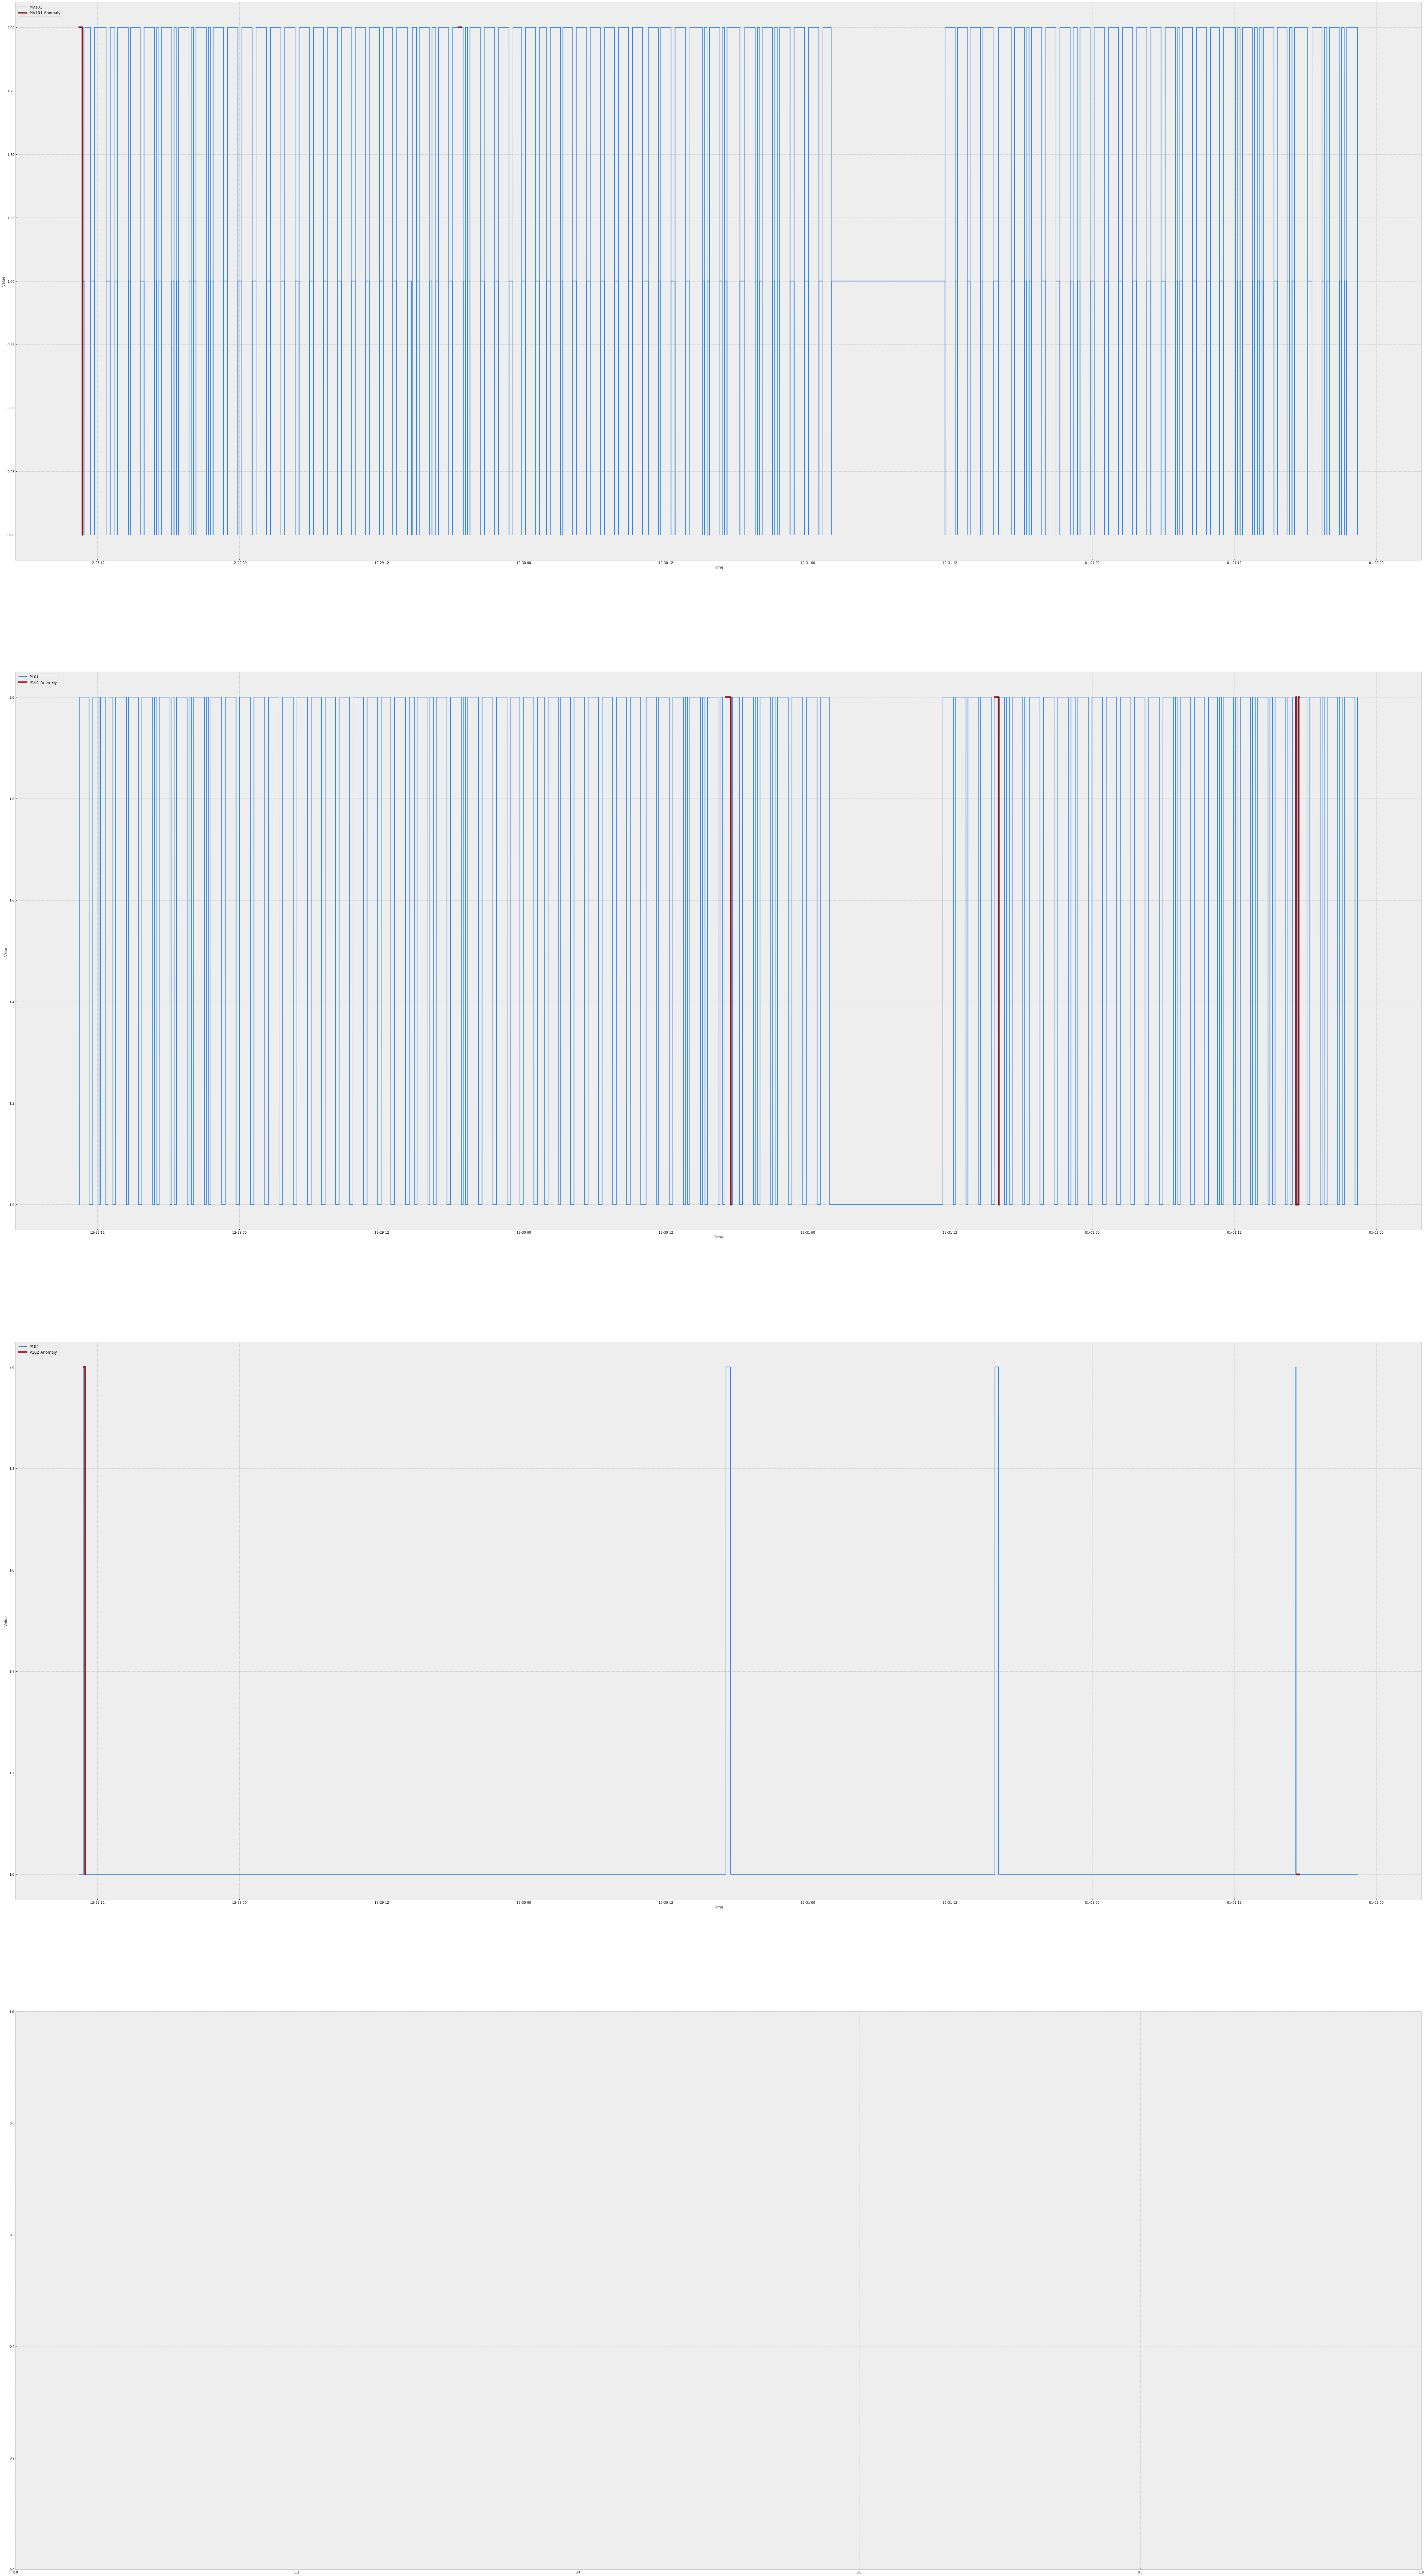

In [6]:
# Visualization Start Time and End Time
stages_for_plotting = [
    "P1",
    "P2",
    "P3",
    "P4",
    "P5",
    "P6",
]

time_delta = np.timedelta64(1, "s")

for stage in stages_for_plotting:
    time_start, time_end = filter.get_times(anomalies, stage)
    time_len = int((time_end - time_start) / time_delta)

    x = time_start + np.arange(0, time_len, 1)
    idx_start = int((time_start - df_time_start) / time_delta)
    idx_end = int((time_end - df_time_start) / time_delta)

    columns = stages[stage]
    df_custom = filter.load_df(df_file_loc, columns)
    # total_columns = int(df_custom.shape[1])
    total_columns = len(columns)

    obj = {
        "file_loc": "../output/stage_%s.png" %(stage), 
        "df": df_custom, 
        "total_columns": total_columns, 
        "time_start": time_start, 
        "time_delta": time_delta, 
        "idx_start": idx_start, 
        "idx_end": idx_end,
        "anomalies": anomalies,
        "x": x
    }
    plot.process(obj)


